In [1]:
# 
import numpy as np
import pandas as pd

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

# Cross validation
from sklearn.model_selection import cross_validate

# Bayes opt
from bayes_opt import BayesianOptimization

# Linear Regression with Lasso
from sklearn.linear_model import Lasso
# Linear Regression with L2
from sklearn.linear_model import Ridge
# Random Forest
from sklearn.ensemble import RandomForestRegressor
# XGBoost
import xgboost as xgb
# LightGBM
import lightgbm as lgbm

# Scoring
from sklearn.metrics import mean_squared_error

# Plotting
import altair as alt

In [2]:
# Versions of packages
import sklearn 
import bayes_opt
import altair
print("numpy:"+np.__version__)
print("pandas:"+pd.__version__)
print("sklearn:"+sklearn.__version__)
# print(bayes_opt.__version__)
print("xgb:"+xgb.__version__)
print("lgbm:"+lgbm.__version__)
print("altair:"+alt.__version__)


numpy:1.16.4
pandas:0.24.2
sklearn:0.22.1
xgb:0.90
lgbm:2.3.1
altair:3.2.0


In [3]:
# bayesian-optimization package version 1.0.1

In [19]:
train_data  = pd.read_csv("../data/processed/train.csv")

In [20]:
train_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,4,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,2,11
2,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,0,14
3,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,0,13
4,GP,M,16,U,LE3,T,4,3,services,other,...,yes,no,5,4,2,1,2,5,6,13


In [22]:
# X_train = train_data.drop(["G3", "G2", "G1"], axis = 1)
X_train = train_data.drop(["G3"], axis = 1)
y_train = train_data["G3"]

In [23]:
X_train.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences'],
      dtype='object')

In [24]:
# Identify numerical vs categorical features
categorical_features = X_train.loc[:,("school","sex", "address", "famsize", "Pstatus", "Mjob", "Fjob", "reason", 
                                  "guardian","schoolsup", "famsup", "paid","activities","nursery", "higher", 
                                  "internet","romantic")].columns

numeric_features = X_train.loc[:,("age", "Medu", "Fedu", "traveltime", "studytime", "failures", "famrel", 
                                    "freetime", "goout", "Dalc", "Walc", "health", "absences")].columns


In [25]:
categorical_features

Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic'],
      dtype='object')

In [26]:
numeric_features

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences'],
      dtype='object')

In [27]:
# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('ohe', OneHotEncoder(drop = "first"), categorical_features)
    ])

In [28]:
# Convert to dataframe
X_train_trans = pd.DataFrame(preprocessor.fit_transform(X_train),
                            index = X_train.index,
                             columns = (list(numeric_features) +
                                       list(preprocessor.named_transformers_['ohe'].get_feature_names(categorical_features))))

# Linear Model Ridge

In [38]:
lmridge_params = {'alpha':(0,100)}

def cv_mse_lmridge(alpha):
    """ 
    Performs cross validation for LM regressor with Ridge regression. To be used for Bayesian optimiser maximizer function.
    
    Parameters
    ----------
    alpha : float
        L2 regularisation constant

    Returns
    -------
    float
        Cross validation score based on negative mean squared error.
        
    """
    estimator = Ridge(alpha)

    # Note that scoring is neg_mean_squared_error, which means higher the score, the better the model
    return cross_validate(estimator, X_train_trans, y_train, cv = 10, scoring = "neg_root_mean_squared_error")["test_score"].mean()

In [42]:
optimizer_lmridge = BayesianOptimization(cv_mse_lmridge, lmridge_params, random_state = 1, verbose = 2)
optimizer_lmridge.maximize(n_iter = 20)

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        | -2.736    |  41.7     |
|  2        | -2.735    |  72.03    |
|  3        | -2.77     |  0.01144  |
|  4        | -2.738    |  30.23    |
|  5        | -2.745    |  14.68    |
|  6        | -2.737    |  100.0    |
|  7        | -2.736    |  86.29    |
|  8        | -2.735    |  58.16    |
|  9        | -2.735    |  63.12    |
|  10       | -2.735    |  52.72    |
|  11       | -2.735    |  72.93    |
|  12       | -2.735    |  62.31    |
|  13       | -2.735    |  51.52    |
|  14       | -2.736    |  78.52    |
|  15       | -2.735    |  64.61    |
|  16       | -2.735    |  55.51    |
|  17       | -2.735    |  66.56    |
|  18       | -2.735    |  48.22    |
|  19       | -2.735    |  62.92    |
|  20       | -2.735    |  70.23    |
|  21       | -2.735    |  58.19    |
|  22       | -2.736    |  84.42    |
|  23       | -2.735    |  57.69    |
|  24       | -2.735    |  67.56    |
|  25       

In [162]:
optimizer_lmridge.max

{'target': -2.735039423513031, 'params': {'alpha': 60.261882871617445}}

# Linear Model Lasso

In [46]:
lmlasso_params = {'alpha':(0.01,100)}

def cv_mse_lmlasso(alpha):
    """ 
    Performs cross validation for LM regressor with Lasso regression. To be used for Bayesian optimiser maximizer function.
    
    Parameters
    ----------
    alpha : float
        L1 regularisation constant

    Returns
    -------
    float
        Cross validation score based on negative mean squared error.
        
    """
    estimator = Lasso(alpha)

    # Note that scoring is neg_mean_squared_error, which means higher the score, the better the model
    return cross_validate(estimator, X_train_trans, y_train, cv = 10, scoring = "neg_root_mean_squared_error")["test_score"].mean()

In [47]:
optimizer_lmlasso = BayesianOptimization(cv_mse_lmlasso, lmlasso_params, random_state = 1)
optimizer_lmlasso.maximize(n_iter = 20)

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        | -3.2      |  41.71    |
|  2        | -3.2      |  72.04    |
|  3        | -2.731    |  0.02144  |
|  4        | -3.2      |  30.24    |
|  5        | -3.2      |  14.68    |
|  6        | -3.2      |  100.0    |
|  7        | -2.744    |  0.01     |
|  8        | -3.2      |  1.969    |
|  9        | -3.2      |  56.88    |
|  10       | -3.2      |  86.02    |
|  11       | -3.2      |  22.46    |
|  12       | -3.2      |  49.29    |
|  13       | -3.2      |  64.46    |
|  14       | -3.2      |  93.01    |
|  15       | -3.2      |  79.03    |
|  16       | -3.2      |  8.788    |
|  17       | -3.2      |  35.97    |
|  18       | -3.2      |  18.57    |
|  19       | -3.2      |  26.35    |
|  20       | -3.2      |  53.08    |
|  21       | -3.2      |  45.5     |
|  22       | -3.2      |  60.66    |
|  23       | -3.2      |  68.24    |
|  24       | -3.2      |  75.53    |
|  25       

# Random Forest

In [54]:
# SKLearn Random Forest
rf_params = {'n_estimators':(10,150), 'max_depth':(10,200), 'max_features':(2, 30)}

def cv_mse_rf(n_estimators,max_depth, max_features):
    """ 
    Performs cross validation for Random Forest Regressor. To be used for Bayesian optimiser maximizer function.
    
    Parameters
    ----------
    n_estimators : float
        Number of estimators for random forest
    max_depth : float
        Max depth of trees in random forest
    max_features : float
        Max number of features in random forest

    Returns
    -------
    float
        Cross validation score based on negative mean squared error.
        
    """
    # Convert chosen hyperparams to discrete integer
    max_depth = int(max_depth)
    max_features = int(max_features)
    n_estimators = int(n_estimators)
    
    estimator = RandomForestRegressor(n_estimators = n_estimators, max_depth = max_depth, max_features = max_features)

    # Note that scoring is neg_mean_squared_error, which means higher the score, the better the model
    return cross_validate(estimator, X_train_trans, y_train, cv = 10, scoring = "neg_root_mean_squared_error")["test_score"].mean()

In [55]:
optimizer_rf = BayesianOptimization(cv_mse_rf, rf_params, random_state = 1)
optimizer_rf.maximize(n_iter = 30)

|   iter    |  target   | max_depth | max_fe... | n_esti... |
-------------------------------------------------------------
|  1        | -2.9      |  89.23    |  22.17    |  10.02    |
|  2        | -2.717    |  67.44    |  6.109    |  22.93    |
|  3        | -2.65     |  45.39    |  11.68    |  65.55    |
|  4        | -2.672    |  112.4    |  13.74    |  105.9    |
|  5        | -2.775    |  48.85    |  26.59    |  13.83    |
|  6        | -2.705    |  200.0    |  2.0      |  150.0    |
|  7        | -2.729    |  10.0     |  2.0      |  150.0    |
|  8        | -2.914    |  10.0     |  2.0      |  10.0     |
|  9        | -2.712    |  83.69    |  30.0     |  150.0    |
|  10       | -2.728    |  200.0    |  2.0      |  55.75    |
|  11       | -2.725    |  200.0    |  30.0     |  109.0    |
|  12       | -2.726    |  80.2     |  2.0      |  150.0    |
|  13       | -2.699    |  10.0     |  30.0     |  115.2    |
|  14       | -2.705    |  171.7    |  2.0      |  102.7    |
|  15   

# XGBoost

In [56]:
# XGBoost Regressor
xgb_params = {'n_estimators':(10, 150), 'max_depth':(10, 200), 'learning_rate':(0.001, 1),
              'subsample':(0, 1), 'gamma':(0, 50), 'reg_alpha':(0, 100), 'reg_lambda':(0, 100)}

def cv_mse_xgb(n_estimators, max_depth, learning_rate, subsample, gamma, reg_alpha, reg_lambda):
    """ 
    Performs cross validation for Random Forest Regressor. To be used for Bayesian optimiser maximizer function.
    
    Parameters
    ----------
    n_estimators : float
        Number of estimators
    max_depth : float
        Max depth of trees
    learning_rate : float
        Learning rate
    subsample : float
        Subsample ratio of training instances 
    gamma : float
        Min loss reduction to make further partition on leaf node   
    reg_alpha : float
        L1 regularisation
    reg_lambda : float
        L2 regularisation

    Returns
    -------
    float
        Cross validation score based on negative mean squared error.
        
    """
    # Convert chosen hyperparams to discrete integer
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    
    estimator = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators = n_estimators, 
                                 max_depth = max_depth, 
                                 learning_rate = learning_rate, 
                                 subsample = subsample,
                                 gamma = gamma, 
                                 reg_alpha = reg_alpha, 
                                 reg_lambda = reg_lambda)

    # Note that scoring is neg_mean_squared_error, which means higher the score, the better the model
    return cross_validate(estimator, X_train_trans, y_train, cv = 10, scoring = "neg_root_mean_squared_error")["test_score"].mean()

In [57]:
# Warnings due to some current issue with xgboost incompatibility with pandas deprecation
# Fix will be for upcoming xgboost version 1.0.0, but latest version is only 0.90
# See https://github.com/dmlc/xgboost/issues/4300
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Fixed random state due to xgboost hyper param combination throwing a result for NaN
optimizer_xgb = BayesianOptimization(cv_mse_xgb, xgb_params, random_state = 1)
optimizer_xgb.maximize(n_iter = 30)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -2.909    |  20.85    |  0.7206   |  10.02    |  52.33    |  14.68    |  9.234    |  0.1863   |
|  2        | -2.729    |  17.28    |  0.3974   |  112.4    |  68.69    |  68.52    |  20.45    |  0.8781   |
|  3        | -2.953    |  1.369    |  0.6708   |  89.29    |  88.22    |  14.04    |  19.81    |  0.8007   |
|  4        | -4.358    |  48.41    |  0.3141   |  141.5    |  132.7    |  89.46    |  8.504    |  0.03905  |
|  5        | -2.728    |  8.492    |  0.8783   |  28.69    |  68.96    |  95.79    |  53.32    |  0.6919   |
|  6        | -11.71    |  0.0      |  0.001    |  123.6    |  10.0     |  41.37    |  100.0    |  1.0      |
|  7        | -2.818    |  12.94    |  0.6685   |  70.0     |  76.44    |  57.11    |  20.76    |  0.7061   |
|  8      

# LightGBM


In [59]:
# LightGBM
lgbm_params = {'n_estimators':(10, 150), 'max_depth':(10, 200), 'learning_rate':(0.001, 1),
               'reg_alpha':(0, 100), 'reg_lambda':(0, 100)}

def cv_mse_lgbm(n_estimators, max_depth, learning_rate, reg_alpha, reg_lambda):
    """ 
    Performs cross validation for Random Forest Regressor. To be used for Bayesian optimiser maximizer function.
    
    Parameters
    ----------
    n_estimators : float
        Number of estimators
    max_depth : float
        Max depth of trees
    learning_rate : float
        Learning rate
    reg_alpha : float
        L1 regularisation
    reg_lambda : float
        L2 regularisation

    Returns
    -------
    float
        Cross validation score based on negative mean squared error.
        
    """
    # Convert chosen hyperparams to discrete integer
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    
    estimator = lgbm.LGBMRegressor(n_estimators = n_estimators, 
                                 max_depth = max_depth, 
                                 learning_rate = learning_rate, 
                                 reg_alpha = reg_alpha, 
                                 reg_lambda = reg_lambda)
    
    # Note that scoring is neg_mean_squared_error, which means higher the score, the better the model
    return cross_validate(estimator, X_train_trans, y_train, cv = 10, scoring = "neg_root_mean_squared_error")["test_score"].mean()

In [60]:
# Fixed random state due to xgboost hyper param combination throwing a result for NaN
optimizer_lgbm = BayesianOptimization(cv_mse_lgbm, lgbm_params, random_state = 1)
optimizer_lgbm.maximize(n_iter = 30)

|   iter    |  target   | learni... | max_depth | n_esti... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------
|  1        | -2.727    |  0.4176   |  146.9    |  10.02    |  30.23    |  14.68    |
|  2        | -2.749    |  0.09325  |  45.39    |  58.38    |  39.68    |  53.88    |
|  3        | -2.809    |  0.4198   |  140.2    |  38.62    |  87.81    |  2.739    |
|  4        | -2.802    |  0.6708   |  89.29    |  88.22    |  14.04    |  19.81    |
|  5        | -2.79     |  0.8009   |  194.0    |  53.88    |  69.23    |  87.64    |
|  6        | -2.769    |  1.0      |  10.0     |  10.0     |  4.931e-1 |  100.0    |
|  7        | -3.167    |  0.001    |  10.0     |  150.0    |  100.0    |  100.0    |
|  8        | -3.19     |  0.001    |  10.0     |  10.0     |  0.0      |  0.0      |
|  9        | -3.136    |  0.001    |  200.0    |  150.0    |  0.0      |  100.0    |
|  10       | -2.823    |  1.0      |  92.09    |  10.

In [108]:
# Compare the best models
cv_rmse = [-optimizer_lmlasso.max['target'], 
             -optimizer_lmridge.max['target'], 
             -optimizer_rf.max['target'],
             -optimizer_xgb.max['target'],
             -optimizer_lgbm.max['target']]

models = ["lm_lasso", "lm_ridge", "randomforest", "xgb", "lgbm"]

cv_df = pd.DataFrame(cv_rmse, index = models, columns = ["cv_score"])

# Output to csv
cv_df.to_csv("../data/output/cv_results.csv")

cv_df

,cv_score
lm_lasso,2.731073
lm_ridge,2.735046
randomforest,2.649802
xgb,2.727777
lgbm,2.726576


In [109]:
# Adjusting discrete hyperparam for certain models
rf_hyperparam = optimizer_rf.max['params']
rf_hyperparam['max_depth'] = int(rf_hyperparam['max_depth'])
rf_hyperparam['max_features'] = int(rf_hyperparam['max_features'])
rf_hyperparam['n_estimators'] = int(rf_hyperparam['n_estimators'])

xgb_hyperparam = optimizer_xgb.max['params']
xgb_hyperparam['max_depth'] = int(xgb_hyperparam['max_depth'])
xgb_hyperparam['n_estimators'] = int(xgb_hyperparam['n_estimators'])

lgbm_hyperparam = optimizer_lgbm.max['params']
lgbm_hyperparam['max_depth'] = int(lgbm_hyperparam['max_depth'])
lgbm_hyperparam['n_estimators'] = int(lgbm_hyperparam['n_estimators'])

In [74]:
# Store as Series for writing to csv
lmlasso_hyperparam_series = pd.Series(optimizer_lmlasso.max['params'])

lmridge_hyperparam_series = pd.Series(optimizer_lmridge.max['params'])

rf_hyperparam_series = pd.Series(rf_hyperparam)

xgb_hyperparam_series = pd.Series(xgb_hyperparam)

lgbm_hyperparam_series = pd.Series(lgbm_hyperparam)

In [75]:
# Output model params to csv
lmlasso_hyperparam_series.to_csv("../data/output/lmlasso_hyperparam.csv", header = False)
lmridge_hyperparam_series.to_csv("../data/output/lmridge_hyperparam.csv", header = False)
rf_hyperparam_series.to_csv("../data/output/rf_hyperparam.csv", header = False)
xgb_hyperparam_series.to_csv("../data/output/xgb_hyperparam.csv", header = False)
lgbm_hyperparam_series.to_csv("../data/output/lgbm_hyperparam.csv", header = False)

# Read hyperparams from stored output

In [10]:
# Optional: Read in stored hyperparams. To be used when restart from offline
lmlasso_hyperparam_series = pd.Series.from_csv("../data/output/lmlasso_hyperparam.csv")

lmridge_hyperparam_series = pd.Series.from_csv("../data/output/lmridge_hyperparam.csv")

rf_hyperparam_series = pd.Series.from_csv("../data/output/rf_hyperparam.csv")

xgb_hyperparam_series = pd.Series.from_csv("../data/output/xgb_hyperparam.csv")

lgbm_hyperparam_series = pd.Series.from_csv("../data/output/lgbm_hyperparam.csv")

/home/kenneth/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:4141: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


In [11]:
lmlasso_hyperparam = dict()
for i in lmlasso_hyperparam_series.index:
    lmlasso_hyperparam[i] = lmlasso_hyperparam_series[i]

lmlasso_hyperparam

{'alpha': 0.012437367359671318}

In [12]:
lmridge_hyperparam = dict()
for i in lmridge_hyperparam_series.index:
    lmridge_hyperparam[i] = lmridge_hyperparam_series[i]

lmridge_hyperparam

{'alpha': 61.79340127008997}

In [13]:
rf_hyperparam = dict()
for i in rf_hyperparam_series.index:
    rf_hyperparam[i] = rf_hyperparam_series[i]

rf_hyperparam

{'max_depth': 112, 'max_features': 13, 'n_estimators': 105}

In [14]:
xgb_hyperparam = dict()
for i in xgb_hyperparam_series.index:
    
    # For integer hyperparams
    if i == "max_depth" or i == "n_estimators" or i == "max_features":
        xgb_hyperparam[i] = int(xgb_hyperparam_series[i])
    # For float hyperparams
    else:
        xgb_hyperparam[i] = xgb_hyperparam_series[i]

xgb_hyperparam

{'gamma': 13.241537120773089,
 'learning_rate': 0.8453266130509627,
 'max_depth': 21,
 'n_estimators': 67,
 'reg_alpha': 57.46494917796629,
 'reg_lambda': 29.32489868699375,
 'subsample': 0.4784716853167835}

In [15]:
lgbm_hyperparam = dict()
for i in lgbm_hyperparam_series.index:
    
    # For integer hyperparams
    if i == "max_depth" or i == "n_estimators" or i == "max_features":
        lgbm_hyperparam[i] = int(lgbm_hyperparam_series[i])
    # For float hyperparams
    else:
        lgbm_hyperparam[i] = lgbm_hyperparam_series[i]

lgbm_hyperparam

{'learning_rate': 0.41760498269787133,
 'max_depth': 146,
 'n_estimators': 10,
 'reg_alpha': 30.233257263183976,
 'reg_lambda': 14.675589081711305}

In [16]:
models = ["lm_lasso", "lm_ridge", "randomforest", "xgb", "lgbm"]

# Create models and score

In [29]:
best_lasso = Lasso(random_state = 1).set_params(**lmlasso_hyperparam)
best_lasso.fit(X_train_trans, y_train)

Lasso(alpha=0.012437367359671318, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=1, selection='cyclic', tol=0.0001, warm_start=False)

In [30]:
best_ridge = Ridge(random_state = 1).set_params(**lmridge_hyperparam)
best_ridge.fit(X_train_trans, y_train)

Ridge(alpha=61.79340127008997, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=1, solver='auto', tol=0.001)

In [31]:
best_rf = RandomForestRegressor(random_state = 1).set_params(**rf_hyperparam)
best_rf.fit(X_train_trans, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=112, max_features=13, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=105, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [32]:
best_xgb = xgb.XGBRegressor(random_state = 1).set_params(**xgb_hyperparam)
best_xgb.fit(X_train_trans, y_train)

/home/kenneth/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/kenneth/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[10:32:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=13.241537120773089,
             importance_type='gain', learning_rate=0.8453266130509627,
             max_delta_step=0, max_depth=21, min_child_weight=1, missing=None,
             n_estimators=67, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=1, reg_alpha=57.46494917796629,
             reg_lambda=29.32489868699375, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.4784716853167835, verbosity=1)

In [33]:
best_lgbm = lgbm.LGBMRegressor(random_state = 1).set_params(**lgbm_hyperparam)
best_lgbm.fit(X_train_trans, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.41760498269787133,
              max_depth=146, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=10, n_jobs=-1, num_leaves=31,
              objective=None, random_state=1, reg_alpha=30.233257263183976,
              reg_lambda=14.675589081711305, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

# Test Data Preprocessing

In [34]:
# Test set
test_data  = pd.read_csv("../data/processed/test.csv")

# X_test = test_data.drop(["G3", "G2", "G1"], axis = 1)
X_test = test_data.drop(["G3"], axis = 1)
y_test = test_data["G3"]

In [35]:
# Convert to dataframe
X_test_trans = pd.DataFrame(preprocessor.fit_transform(X_test),
                            index = X_test.index,
                             columns = (list(numeric_features) +
                                       list(preprocessor.named_transformers_['ohe'].get_feature_names(categorical_features))))

# Test Data Prediction

In [36]:
test_rmse = []
test_rmse.append(np.sqrt(mean_squared_error(y_test, best_lasso.predict(X_test_trans))))
test_rmse.append(np.sqrt(mean_squared_error(y_test, best_ridge.predict(X_test_trans))))
test_rmse.append(np.sqrt(mean_squared_error(y_test, best_rf.predict(X_test_trans))))
test_rmse.append(np.sqrt(mean_squared_error(y_test, best_xgb.predict(X_test_trans))))
test_rmse.append(np.sqrt(mean_squared_error(y_test, best_lgbm.predict(X_test_trans))))

# Convert to Dataframe
test_rmse = pd.DataFrame(test_rmse, index= models, columns = ["test_rmse"])
test_rmse = test_rmse.sort_values(by="test_rmse", ascending = True)
test_rmse

,test_rmse
randomforest,2.417248
xgb,2.452847
lm_ridge,2.481202
lm_lasso,2.483605
lgbm,2.577540


In [37]:
# Create dictionary of all models
models_dict = dict()
models_dict["lm_lasso"] = best_lasso
models_dict["lm_ridge"] = best_ridge
models_dict["randomforest"] = best_rf
models_dict["xgb"] = best_xgb
models_dict["lgbm"] = best_lgbm

In [38]:
best_model = models_dict[list(test_rmse.head(1).index)[0]]

In [39]:
# Best model
print(test_rmse.head(1))

              test_rmse
randomforest   2.417248


In [40]:
# If model is linear regression model, use "coef_" to extract weights
if best_model ==best_lasso or best_model == best_ridge:
    feat_importance = pd.DataFrame(best_model.coef_, index = X_train_trans.columns, columns = ["Importance"])

# If model is tree based, use "feature_importances" to extract importances    
else: 
    feat_importance = pd.DataFrame(best_model.feature_importances_, index = X_train_trans.columns, columns = ["Importance"])

In [41]:
feat_importance = feat_importance.sort_values(by = "Importance", ascending = False).reset_index()

In [42]:
feat_importance.to_csv("../data/output/feat_importance.csv")

In [43]:
feat_importance

,index,Importance
0,failures,0.140053
1,absences,0.064478
2,age,0.047967
3,Walc,0.047830
4,school_MS,0.047253
5,goout,0.042354
6,Medu,0.041735
7,Dalc,0.040815
8,Fedu,0.039364
9,health,0.039161


In [112]:
# https://github.com/nipunbatra/50-ggplot-python/blob/master/Altair/DivergingLollipop.ipynb
import altair as alt

c1 = alt.Chart(feat_importance.head(10)).mark_bar(color='pink', size = 5).encode(
    y=alt.Y('index', sort=alt.EncodingSortField(order='descending', field='Importance'), title = None),
    x=alt.X('Importance')
)

In [113]:
c2 = alt.Chart(feat_importance.head(10)).mark_circle(color='lightblue', size=1200).encode(
    y=alt.Y('index', sort=alt.EncodingSortField(order='descending', field='Importance')),
    x=alt.X('Importance' ), 
    text='Importance'
)

In [114]:
c3 = alt.Chart(feat_importance.head(10)).mark_text(color='black').encode(
    y=alt.Y('index', sort=alt.EncodingSortField(order='descending', field='Importance')),
    x=alt.X('Importance' ), 
    text='Importance'
)

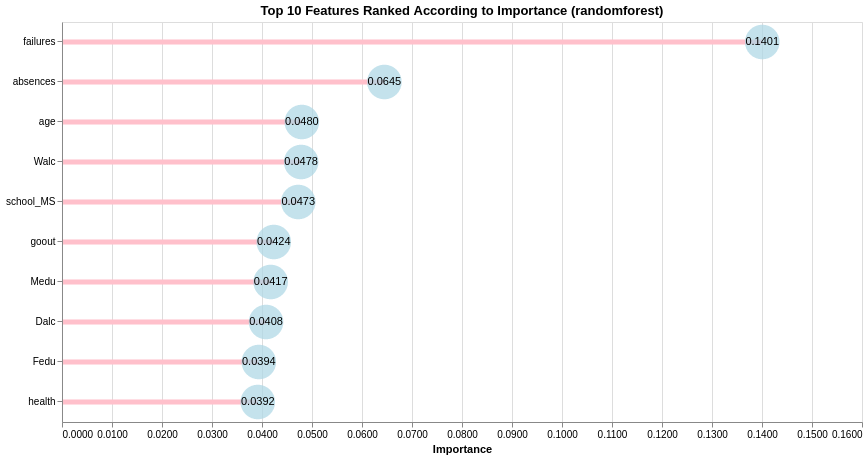

In [116]:
chart = alt.layer(c1,c2,c3)
chart.configure(
    numberFormat="0.4f"
).properties(
    title = "Top 10 Features Ranked According to Importance ("+list(test_rmse.head(1).index)[0]+")",
    width = 800,
    height = 400
)

In [102]:
chart.save("../img/ranked_features.png")

In [108]:
abc = "./onetwothree/"
qwe = "./one"

In [107]:
abc[-1]

'/'

In [110]:
qwe[-1] != "/"

True

In [111]:
abc[-3:]

'ee/'